### Krakencoder usage example

This notebook provides an example of how to load connectome data and apply a pretrained Krakencoder model to that data.

The process is as follows:
1.   Load model
2.   Load new data and do mild domain adaptation (map input data mean to training data mean)
3.   Transform each input data flavor into 128-dimensional latent space
4.   Average latent space across all types ("fusion") or across only SC data ("fusionSC")
  * Note: this might be used for prediction, clustering, etc.
5.   Transform "fusion" averaged latent vectors to output connectomes



In [1]:
import torch
import os
import numpy as np
from scipy.io import savemat

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from krakencoder.model import Krakencoder
from krakencoder.adaptermodel import KrakenAdapter
from krakencoder.utils import square2tri, tri2square, numpyvar
from krakencoder.data import generate_adapt_transformer, load_transformers_from_file
from krakencoder.fetch import fetch_model_data
from krakencoder import loss

import kraken_jupyter_functions as kjf

In [2]:
data_folder="/home/jovyan/shared/krakencoder/model_data/"

# load model checkpoint and precomputed PCA transforms
# The first time these are used, they are downloaded to package_dir/model_data (~1.3GB)
# To use an alternate storage location, you can set the KRAKENCODER_DATA environment variable
checkpoint_file=fetch_model_data('kraken_chkpt_SCFC_fs86+shen268+coco439_pc256_225paths_latent128_20240413_ep002000.pt', 
                                 data_folder="/home/jovyan/shared/krakencoder/model_data/")

In [3]:
ioxfm_file_list=fetch_model_data(['kraken_ioxfm_SCFC_fs86_pc256_710train.npy',
                                  'kraken_ioxfm_SCFC_shen268_pc256_710train.npy',
                                  'kraken_ioxfm_SCFC_coco439_pc256_710train.npy'], 
                                  data_folder=data_folder)

In [4]:
inner_net, checkpoint_info = Krakencoder.load_checkpoint(checkpoint_file, eval_mode=True)

In [5]:
transformer_list, transformer_info_list = load_transformers_from_file(ioxfm_file_list)

Loading precomputed input transformations: /home/jovyan/shared/krakencoder/model_data/kraken_ioxfm_SCFC_fs86_pc256_710train.npy
Loading precomputed input transformations: /home/jovyan/shared/krakencoder/model_data/kraken_ioxfm_SCFC_shen268_pc256_710train.npy
Loading precomputed input transformations: /home/jovyan/shared/krakencoder/model_data/kraken_ioxfm_SCFC_coco439_pc256_710train.npy


In [6]:
#create new model that wraps the inner kraken model and includes PCA transforms from raw data
net=KrakenAdapter(inner_model=inner_net,
                  data_transformer_list=[transformer_list[conntype] for conntype in checkpoint_info['input_name_list']],
                  linear_polynomial_order=0,
                  eval_mode=True)

In [7]:
### Load connectivity data files
* Data should be a BIDS(ish) .zip file with a set of ROIxROI .tsv files for each connectome
* File must contain a `participants_info.tsv` with a row for each subject, including BIDS `participant_id`, etc...
* Each tsv file should be `sub-<subject>_atlas-<atlas>_meas-<flavor>_relmat.dense.tsv`
    * where `<atlas>` could be `fs86`, `shen268`, `coco439`, etc...
    * and `<flavor>` could be `FCcorrHPF`, `FCcorrHPFGSR`, `FCpcorrHPF`, `SCsdstreamVN`, `SCifod2actVN`, etc...

conndata_squaremats['SCifod2act_fs86_volnorm']['data'] (10,) (86, 86)
 -> conndata['SCifod2act_fs86_volnorm']['data'] (10, 3655)
conndata_squaremats['SCsdstream_fs86_volnorm']['data'] (10,) (86, 86)
 -> conndata['SCsdstream_fs86_volnorm']['data'] (10, 3655)
conndata_squaremats['FCcorr_fs86_hpf']['data'] (10,) (86, 86)
 -> conndata['FCcorr_fs86_hpf']['data'] (10, 3655)
conndata_squaremats['FCcorr_fs86_hpfgsr']['data'] (10,) (86, 86)
 -> conndata['FCcorr_fs86_hpfgsr']['data'] (10, 3655)
conndata_squaremats['FCpcorr_fs86_hpf']['data'] (10,) (86, 86)
 -> conndata['FCpcorr_fs86_hpf']['data'] (10, 3655)


In [8]:
# compute SIMPLE domain adaptation transform: map mean(input subjects) to mean(training subjects) for each flavor
# and transform each input data flavor to match training data mean
#
# It's not really needed for these data since they are from HCP-YA already, which the model was trained on.
# That is why the model fits are all roughly "y = 1.0*x + 0". It is shown here for demonstration purposes only.
adxfm_dict={}
conndata_adapted={}
for c in conndata:
  print("Adapting %s" % (c))
  adxfm_dict[c]=generate_adapt_transformer(input_data=conndata[c]['data'],
                                           target_data=transformer_info_list[c],
                                           adapt_mode='meanfit+meanshift')
  conndata_adapted[c]={'data':adxfm_dict[c].transform(conndata[c]['data'])}

	Fitting input data mean to transformer mean: modeldata=inputdata*0.992 + -0.000
	Input data mean for adapt has 10 subjects.
	Adapted fit R2: 0.986
	Fitting input data mean to transformer mean: modeldata=inputdata*1.008 + 0.000
	Input data mean for adapt has 10 subjects.
	Adapted fit R2: 0.984
	Fitting input data mean to transformer mean: modeldata=inputdata*0.936 + 0.008
	Input data mean for adapt has 10 subjects.
	Adapted fit R2: 0.952
	Fitting input data mean to transformer mean: modeldata=inputdata*0.935 + -0.001
	Input data mean for adapt has 10 subjects.
	Adapted fit R2: 0.957
	Fitting input data mean to transformer mean: modeldata=inputdata*0.932 + 0.001
	Input data mean for adapt has 10 subjects.
	Adapted fit R2: 0.957


In [9]:
# transform input data to krakencoder latent space
encoded_data={}

#loop through all of the input names from the saved checkpoint,
# because the encoder/decoder indices are in this order.
for encidx, c in enumerate(checkpoint_info['input_name_list']):
  if not c in conndata_adapted:
    #if this input type was not in the example data, skip it
    continue
  with torch.no_grad():
    encoded_data[c]=net(conndata_adapted[c]['data'],encoder_index=encidx, decoder_index=-1)

# compute average latent representation across SC input types
fusion_type='fusionSC'

if fusion_type=='fusion':
  encoded_fusion=torch.mean(torch.stack([encoded_data[c] for c in encoded_data]),axis=0)
elif fusion_type=='fusionSC':
  encoded_fusion=torch.mean(torch.stack([encoded_data[c] for c in encoded_data if c.startswith('SC')]),axis=0)

print("%s latent space representation: " % (fusion_type), kjf.data_shape_string(encoded_fusion))

# Now predict output connectomes from fusion latent representation
# Predictions are stored in predicted_alltypes[inputtype][outputtype]
predicted_alltypes={fusion_type:{}}

for decidx, c in enumerate(checkpoint_info['input_name_list']):
  with torch.no_grad():
    _,pred=net(encoded_fusion,encoder_index=-1, decoder_index=decidx)
  predicted_alltypes[fusion_type][c]=numpyvar(pred) #convert back to numpy for analysis
  print("predicted_alltypes['%s']['%s']: " % (fusion_type,c), kjf.data_shape_string(predicted_alltypes[fusion_type][c]))

#add fusion latent representation to output
predicted_alltypes[fusion_type]['encoded']=numpyvar(encoded_fusion)
print("predicted_alltypes['%s']['%s']: " % (fusion_type,'encoded'), kjf.data_shape_string(predicted_alltypes[fusion_type]['encoded']))

fusion latent space representation:  torch.Size([10, 128])
predicted_alltypes['fusion']['SCifod2act_fs86_volnorm']:  (10, 3655)
predicted_alltypes['fusion']['SCsdstream_fs86_volnorm']:  (10, 3655)
predicted_alltypes['fusion']['FCcorr_fs86_hpf']:  (10, 3655)
predicted_alltypes['fusion']['FCcorr_fs86_hpfgsr']:  (10, 3655)
predicted_alltypes['fusion']['FCpcorr_fs86_hpf']:  (10, 3655)
predicted_alltypes['fusion']['SCifod2act_shen268_volnorm']:  (10, 35778)
predicted_alltypes['fusion']['SCsdstream_shen268_volnorm']:  (10, 35778)
predicted_alltypes['fusion']['FCcorr_shen268_hpf']:  (10, 35778)
predicted_alltypes['fusion']['FCcorr_shen268_hpfgsr']:  (10, 35778)
predicted_alltypes['fusion']['FCpcorr_shen268_hpf']:  (10, 35778)
predicted_alltypes['fusion']['SCifod2act_coco439_volnorm']:  (10, 96141)
predicted_alltypes['fusion']['SCsdstream_coco439_volnorm']:  (10, 96141)
predicted_alltypes['fusion']['FCcorr_coco439_hpf']:  (10, 96141)
predicted_alltypes['fusion']['FCcorr_coco439_hpfgsr']:  (10,

In [10]:
### Quick visualization of an observed and predicted connectivity matrix

Saved exampledata_outputs.mat (23.1 MB)


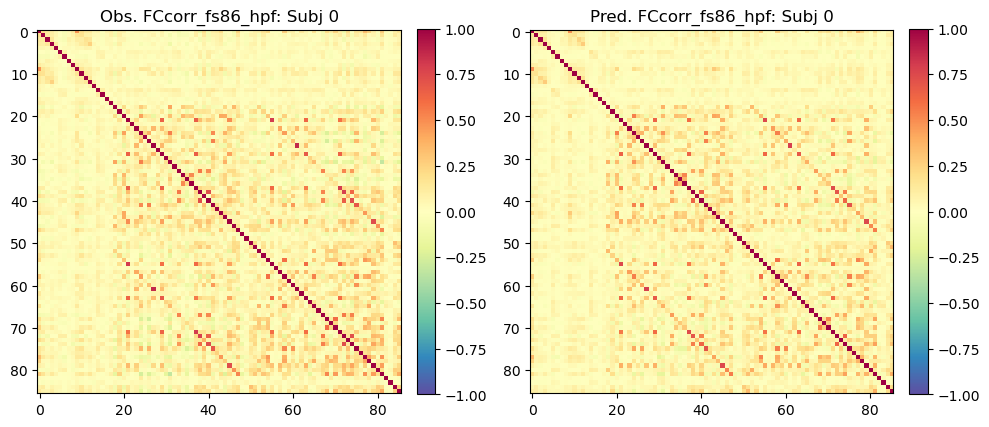

In [11]:
# convert upper tri back to square to display observed and predicted connectomes

conntype='FCcorr_fs86_hpf'

isubj=0

Cobs_square=tri2square(conndata_adapted[conntype]['data'][isubj,:],
                            tri_indices=conndata_triidx[conntype],
                            diagval=1) #diagval=1 for FC
Cpred_square=tri2square(predicted_alltypes[fusion_type][conntype][isubj,:],
                            tri_indices=conndata_triidx[conntype],
                            diagval=1) #diagval=1 for FC

#make sure these are converted back to CPU/numpy before trying to display
Cobs_square=numpyvar(Cobs_square)
Cpred_square=numpyvar(Cpred_square)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
im=plt.imshow(Cobs_square, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=.04)
plt.title('Obs. %s: Subj %s' % (conntype,participants_info.iloc[isubj]['subject']))

plt.subplot(1,2,2)
im=plt.imshow(Cpred_square, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Pred. %s: Subj %s' % (conntype,participants_info.iloc[isubj]['subject']))

plt.tight_layout()
plt.show()

### Demonstration of prediction identifiability
* For each flavor, we look at (SUBJECT)x(SUBJECT) correlations after removing population mean for
    1. Observed vs Observed (measured connectome variability)
    2. Predicted vs Predicted (predicted connetome variability)
    3. Observed vs Predicted (prediction accuracy)
* For Observed vs Predicted, we show the rank for each observed connectome (row) against the set of all predicted connectomes
    * For a perfectly identifiable set of predictions, the rank would be 1 for every row
    * "Average Rank Percentile" is the average of these ranks, expressed as a percentile (1.0=perfect, 0.5=chance)